# Статистика, DS-поток
## Практическое задание 6

В данном задании вы потренируетесь над практическим применением процедуры проверки статистических гипотез на примере критериев согласия, а так же рассмотрите различные модели линейной регрессии.

**Правила:**

* Дедлайн **5 декабря 23:59**. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds20_bot`.
* Прислать нужно ноутбук в формате `ipynb`.
* Решения, размещенные на каких-либо интернет-ресурсах не принимаются. Публикация решения может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качествие основы, ничего не удаляя из него.
* Никакой код из данного задания при проверке запускаться не будет.

**Баллы за задание:**

* Задача 1 — 8 баллов **O2**
* Задача 2 — 12 баллов **O3**
* Задача 3 — 12 баллов **O3**
* Задача 4 — 15 баллов **O2**
* Задача 5 — 10 баллов **O2**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as sps

from scipy.linalg import eigvals
from statsmodels.sandbox.stats.multicomp import multipletests
from tqdm.notebook import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_boston

%matplotlib inline

## Критерии согласия

При решении стоит использовать **готовые реализации критериев из** `scipy.stats`. При возникновении затруднений посмотрите в ноутбук с лекции.
________________
### Задача 1.

С помощью критерия хи-квадрат вам нужно проверить, правильно ли `scipy.stats` генерирует случайные величины. 

**1.** Реализуйте критерий для генерации выборки $U\{1, ..., 10\}$, аналогично разобранному на семинаре. Тем самым проверьте, что `sps.randint` действительно генерирует выборку из равномерного распределения.

In [86]:
sample_size = 1000 # решено выбрать такое, так как 10 ~ log_2 (1000)
sample = sps.randint.rvs(1, 11, size=sample_size)

# Считаем статистику хи-квадрат
chi_stat = sps.chisquare(np.unique(sample, return_counts=True)[1])[0]

# Проверяем с двух сторон как на семинаре
alpha = 0.05
left_q = sps.chi2(df=9).ppf(alpha / 2)
right_q = sps.chi2(df=9).ppf(1 - alpha / 2)
print('Отвергаем H_0?\nОтвет:', chi_stat < left_q or\
      chi_stat > right_q)

Отвергаем H_0?
Ответ: False


**2.** Проверьте, действительно ли код `sps.poisson(mu=5).rvs(size=1000)` генерирует выборку размера 1000 из пуассоновского распределения с параметром 5. 

**Указания**
1. Не забудьте учесть условия применимости критерия хи-квадрат;
2. Для вычисления плотности воспользуйтесь `sps.poisson(mu=5).pmf`;
3. Для подсчета количества элементов в разбиении на множества воспользуйтесь `np.unique(sample, return_counts=True)`;
4. Не нужно писать сколь-либо универсальный код, который одним нажатием кнопки проверяет гипотезу с учетом всех условий применимости критерия. Расписывайте код поэтапно, на каждый логический этап свой код в отдельной ячейке для *конкретной* реализации выборки. Так вам проще реализовать, а нам проще проверять.

In [62]:
sample_size = 1000
sample = sps.poisson(mu=5).rvs(size=1000)
baskets, occurrences = np.unique(sample, return_counts=True)
print('Значения:     ', *baskets,'\nВстречаемость:', *occurrences)

Значения:      0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
Встречаемость: 8 30 87 137 174 177 139 104 61 43 24 11 2 2 1


In [67]:
# Проверим условия применимости критерия
checker = np.empty(shape=baskets.shape, dtype=np.bool)
for i, basket in enumerate(baskets):
    checker[i] = sample_size * sps.poisson(mu=5).pmf(basket) > 5
print('Верно ли, что n*p^0_j >= 5?')
print(*checker)

Верно ли, что n*p^0_j >= 5?
True True True True True True True True True True True True False False False


In [79]:
# Объединим последние 4 группы в одну. Тогда условия применимости выполнятся
merged_baskets = baskets[:-3]
merged_occurrences = occurrences[:-4]
merged_occurrences = np.append(merged_occurrences, np.sum(occurrences[-4:]))
print('Значения:     ', *merged_baskets,'\nВстречаемость:',
      *merged_occurrences)

Значения:      0 1 2 3 4 5 6 7 8 9 10 11 
Встречаемость: 8 30 87 137 174 177 139 104 61 43 24 16


In [85]:
# Считаем статистику хи-квадрат
chi_stat = sps.chisquare(merged_occurrences)[0]

# Проверяем с двух сторон как на семинаре
alpha = 0.05
left_q = sps.chi2(df=9).ppf(alpha / 2)
right_q = sps.chi2(df=9).ppf(1 - alpha / 2)
print('Отвергаем H_0?\nОтвет:', chi_test < left_q or\
      chi_test > right_q)

Отвергаем H_0?
Ответ: False


**Вывод:**

1) Во-первых нужно помнить об условиях применимости критерия хи-квадрат: для хорошего приближения необходимы: $n \ge 50, \forall j\hookrightarrow n p^0_j \ge 5$.

2) Мы не можем сказать, действительно ли код `sps.poisson(mu=5).rvs(size=1000)` генерирует выборку размера 1000 из пуассоновского распределения с параметром 5... Но мы можем сказать, что сгенерированная выборка согласуется с этим распределением. Аналогично и для `sps.randint`: сгенерированная выборка согласуется с равномерным.

__________________
### Задача 2.

На лекциях и семинарах были разобраны следующие критерии проверки нормальности:
* Колмогорова;
* Жарка-Бера;
* Шапиро-Уилка.

Cуществует модификация критерия Колмогорова для проверки нормальности — <a href="https://ru.wikipedia.org/wiki/Критерий_Лиллиефорса"> Критерий Лиллиефорса.</a> При решении задачи можете воспользоваться им, например, взяв реализацию из библиотеки `statsmodels`: <a href="https://www.statsmodels.org/stable/generated/statsmodels.stats.diagnostic.lilliefors.html">`statsmodels.stats.diagnostic.lilliefors`</a>, или же применять для конкретной $F_0$ критерий Колмогорова, пример использования которого можно найти в ноутбуке с лекции.

**1.** Данные критерии являются асимптотическими, и их реальное значение уровня значимости может отличаться от желаемого числа $\alpha=0.05$. На семинарах разобран метод оценки реального уровня значимости критерия. Посчитайте реальный уровень значимости этих критериев для размеров выборки от 5 до 100.

*Подсказка:*

In [ ]:
max_sample_size = ...
sample_count = ...
is_reject_<критерий> = np.zeros((max_sample_size, sample_count))

for i in tqdm(range(max_sample_size)):
    for j in range(sample_count):
        sample = ...
        is_reject_<критерий>[i, j] = ...

Ваша реализация:

In [2]:
max_sample_size = 96 # в цикле будет со сдвигом на 5
samples_count = 10000 # специальное переименовал для лучшего соответствия
alpha = 0.05
is_reject_kolmogorov = np.zeros((max_sample_size, samples_count))
is_reject_shapiro = np.zeros((max_sample_size, samples_count))
is_reject_jarque = np.zeros((max_sample_size, samples_count))

# Используем стандартное нормальное распределение
for i in tqdm(range(max_sample_size)):
    for j in range(samples_count):
        sample = sps.norm.rvs(size=i+5)
        # Сравниваем p-value с alpha и принимаем решение об отвержении
        is_reject_kolmogorov[i, j] =\
        sps.kstest(sample, sps.norm.cdf)[1] <= alpha
        is_reject_shapiro[i, j] =\
        sps.shapiro(sample)[1] <= alpha
        is_reject_jarque[i, j] =\
        sps.jarque_bera(sample)[1] <= alpha

# Применяем метод Монте-Карло для индикаторов => получим оценку реального
# уровня значимости в зависимости от размера выборки
real_alpha_kolmogorov = is_reject_kolmogorov.mean(axis=1)
real_alpha_shapiro = is_reject_shapiro.mean(axis=1)
real_alpha_jarque = is_reject_jarque.mean(axis=1)

Поясните, почему вы выбрали такое значение `sample_count`.

**Ответ.** На семинаре мы показывали, что для достижения точности $0.01$ с вероятностью $0.95\ k$ должно удовлетворять условию: $0.01 \approx \frac{2}{\sqrt{k}}$. Таким образом, $k \approx 10^4$.

Нарисуйте на одном графике зависимость реального уровня значимости от размера выборки для каждого критерия. Пунктиром отметьте уровень 0.05. Не забудьте добавить легенду и подписать оси.

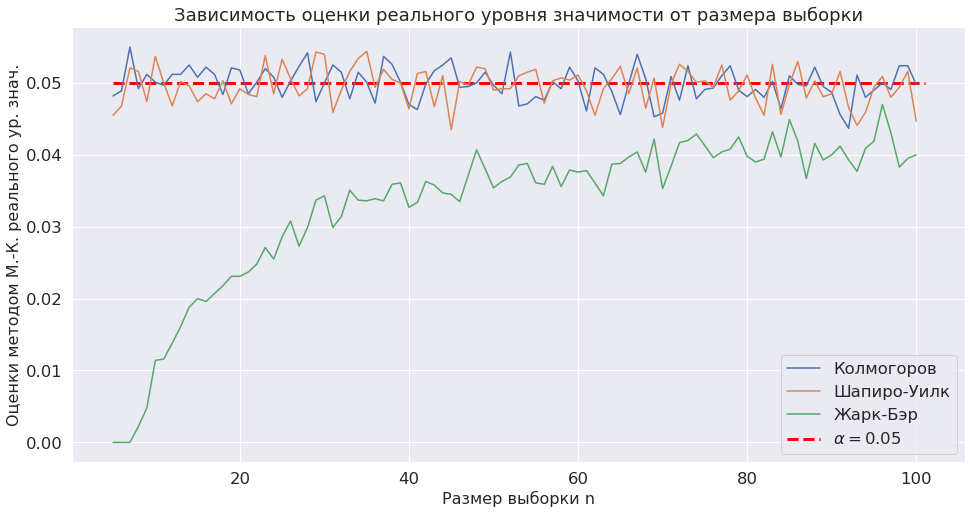

In [3]:
sns.set(style='darkgrid', font_scale=1.5)

plt.figure(figsize=(16, 8))
plt.plot(np.arange(max_sample_size) + 5, real_alpha_kolmogorov,
         label='Колмогоров')
plt.plot(np.arange(max_sample_size) + 5, real_alpha_shapiro,
         label='Шапиро-Уилк')
plt.plot(np.arange(max_sample_size) + 5, real_alpha_jarque, label='Жарк-Бэр')
plt.hlines(0.05, 5, 101, color='red', ls='--',
           label=r'$\alpha = 0.05$', lw=3)
plt.title('Зависимость оценки реального уровня значимости от размера выборки')
plt.xlabel('Размер выборки n', fontsize=16)
plt.ylabel('Оценки методом М.-К. реального ур. знач.', fontsize=16)
plt.legend();

Какой можно сделать вывод?

**Вывод.** Для критериев Колмогорова и Шапиро-Уилка оценка реального уровня значимости часто превосходит $\alpha = 0.05$, а вот критерий Жарка-Бэра строго меньше $\alpha = 0.05$. Поэтому с точки зрения минимизации ошибки первого рода при небольших размерах выборки стоит отдавать предпочтение критерию Жарка-Бэра.

**2.** Аналогичным образом можно вычислять мощность критерия. Вычислите мощности критериев для размеров выборки от 5 до 100, если альтернативная гипотеза заключается в том, что выборка имеет стандартное распределение Коши. Иначе говоря, для критерия $S$ надо приближенно посчитать $\beta_S(\mathsf{P})$, где $\mathsf{P}$ — стандартное распределение Коши.

Нарисуйте на одном графике зависимость мощности критерия от размера выборки для каждого критерия. Не забудьте добавить легенду и подписать оси.


In [14]:
max_sample_size = 96 # в цикле будет со сдвигом на 5
samples_count = 10000 # специальное переименовал для лучшего соответствия
alpha = 0.05
is_reject_kolmogorov = np.zeros((max_sample_size, samples_count))
is_reject_shapiro = np.zeros((max_sample_size, samples_count))
is_reject_jarque = np.zeros((max_sample_size, samples_count))

for i in tqdm(range(max_sample_size)):
    for j in range(samples_count):
        sample = sps.cauchy.rvs(size=i+5)
        # Сравниваем p-value с alpha и принимаем решение об отвержении
        is_reject_kolmogorov[i, j] =\
        sps.kstest(sample, sps.norm.cdf)[1] <= alpha
        is_reject_shapiro[i, j] =\
        sps.shapiro(sample)[1] <= alpha
        is_reject_jarque[i, j] =\
        sps.jarque_bera(sample)[1] <= alpha

# Применяем метод Монте-Карло для индикаторов => получим оценку
# мощности при заданном альтернативном распределении
power_kolmogorov = is_reject_kolmogorov.mean(axis=1)
power_shapiro = is_reject_shapiro.mean(axis=1)
power_jarque = is_reject_jarque.mean(axis=1)

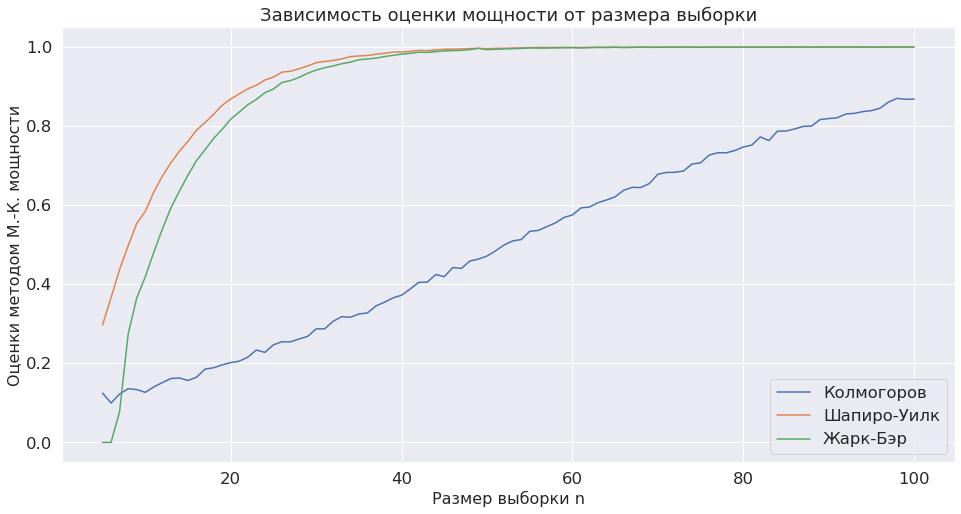

In [15]:
plt.figure(figsize=(16, 8))
plt.plot(np.arange(max_sample_size) + 5, power_kolmogorov, label='Колмогоров')
plt.plot(np.arange(max_sample_size) + 5, power_shapiro, label='Шапиро-Уилк')
plt.plot(np.arange(max_sample_size) + 5, power_jarque, label='Жарк-Бэр')
plt.title('Зависимость оценки мощности от размера выборки')
plt.xlabel('Размер выборки n', fontsize=16)
plt.ylabel('Оценки методом М.-К. мощности', fontsize=16)
plt.legend();

Сделайте вывод. Какой критерий является наиболее мощным при данной альтернативе?

**Вывод.** Как и должно быть по теории, самым мощным является критерий Шапиро-Уилка. Также можно отметить, что у критерия Колмогорова слабо растёт мощность с ростом $n$: при $40$ у двух других критериев мощность уже почти 1, а у критерия Колмогорова всего лишь $0.4$.

**3.** Распределение Стьюдента является в некотором смысле обобщением нормального распределения (при бесконечном количестве степеней свободы) и распределения Коши (при одной степени свободы). 
Посчитайте приближенно мощности критериев для выборки размера 50 если альтернатива заключается в том, что выборка имеет распределение Стьюдента. Поскольку мощность критерия является функцией от распределения из альтернативной гипотезы, вам нужно посчитать функцию. Посчитайте её значения для целых значений степени свободы от 1 до 10.

Нарисуйте на одном графике зависимость мощности критерия от количества степеней свободы для каждого критерия. Не забудьте добавить легенду и подписать оси.

In [7]:
sample_size = 50
samples_count = 10000 # специальное переименовал для лучшего соответствия
alpha = 0.05
max_df = 10 # Максимальное число степеней свободы
is_reject_kolmogorov = np.zeros((max_df, samples_count))
is_reject_shapiro = np.zeros((max_df, samples_count))
is_reject_jarque = np.zeros((max_df, samples_count))

for i in tqdm(range(max_df)):
    for j in range(samples_count):
        sample = sps.t.rvs(df=i+1, size=sample_size)
        # Сравниваем p-value с alpha и принимаем решение об отвержении
        is_reject_kolmogorov[i, j] =\
        sps.kstest(sample, sps.norm.cdf)[1] <= alpha
        is_reject_shapiro[i, j] =\
        sps.shapiro(sample)[1] <= alpha
        is_reject_jarque[i, j] =\
        sps.jarque_bera(sample)[1] <= alpha

# Применяем метод Монте-Карло для индикаторов => получим оценку
# мощности при заданном альтернативном распределении
power_kolmogorov = is_reject_kolmogorov.mean(axis=1)
power_shapiro = is_reject_shapiro.mean(axis=1)
power_jarque = is_reject_jarque.mean(axis=1)

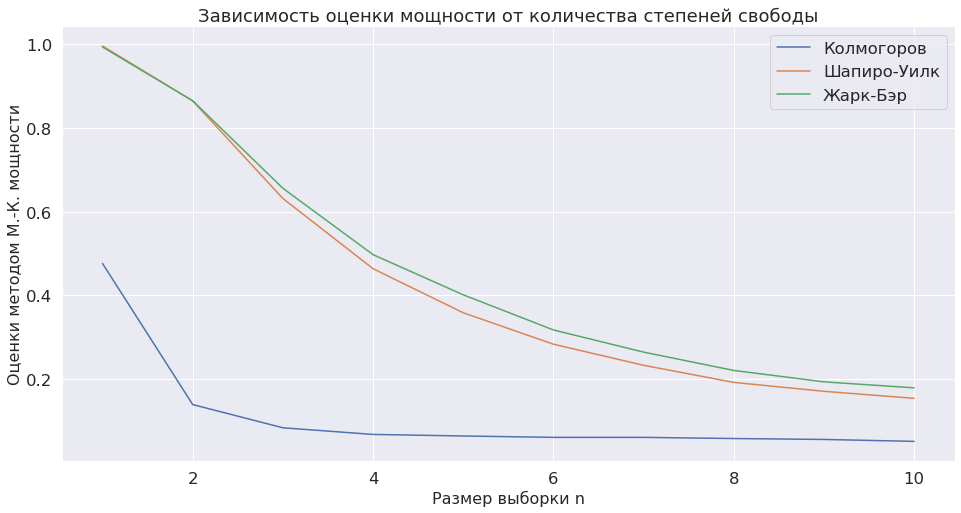

In [8]:
plt.figure(figsize=(16, 8))
plt.plot(np.arange(max_df) + 1, power_kolmogorov, label='Колмогоров')
plt.plot(np.arange(max_df) + 1, power_shapiro, label='Шапиро-Уилк')
plt.plot(np.arange(max_df) + 1, power_jarque, label='Жарк-Бэр')
plt.title('Зависимость оценки мощности от количества степеней свободы')
plt.xlabel('Размер выборки n', fontsize=16)
plt.ylabel('Оценки методом М.-К. мощности', fontsize=16)
plt.legend();

Сделайте вывод относительно мощности критерия при разных распределениях из альтернативы.

**Вывод.** С ростом числа степеней свободы мощность всех критериев стремится к $0$ при фиксированном размере выборки, причём критерий Колмогорова делает это быстрее остальных. Это и согласуется с теорией, ведь при стремлении числа степеней к $\infty$ распределение Стьюдента сходится к нормальному распределению.

**4.** Аналогичным образом посчитайте мощности критериев, если альтернативная гипотеза заключается в том, что выборка имеет экспоненциальное распределение.

In [9]:
max_sample_size = 96 # в цикле будет со сдвигом на 5
samples_count = 10000 # специальное переименовал для лучшего соответствия
alpha = 0.05
is_reject_kolmogorov = np.zeros((max_sample_size, samples_count))
is_reject_shapiro = np.zeros((max_sample_size, samples_count))
is_reject_jarque = np.zeros((max_sample_size, samples_count))

for i in tqdm(range(max_sample_size)):
    for j in range(samples_count):
        sample = sps.expon.rvs(size=i+5)
        # Сравниваем p-value с alpha и принимаем решение об отвержении
        is_reject_kolmogorov[i, j] =\
        sps.kstest(sample, sps.norm.cdf)[1] <= alpha
        is_reject_shapiro[i, j] =\
        sps.shapiro(sample)[1] <= alpha
        is_reject_jarque[i, j] =\
        sps.jarque_bera(sample)[1] <= alpha

# Применяем метод Монте-Карло для индикаторов => получим оценку
# мощности при заданном альтернативном распределении
power_kolmogorov = is_reject_kolmogorov.mean(axis=1)
power_shapiro = is_reject_shapiro.mean(axis=1)
power_jarque = is_reject_jarque.mean(axis=1)

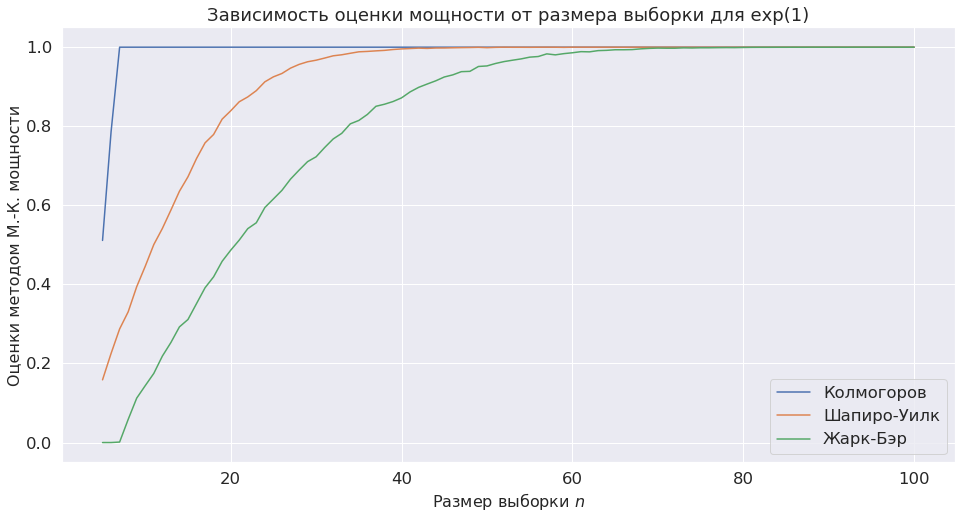

In [13]:
plt.figure(figsize=(16, 8))
plt.plot(np.arange(max_sample_size) + 5, power_kolmogorov, label='Колмогоров')
plt.plot(np.arange(max_sample_size) + 5, power_shapiro, label='Шапиро-Уилк')
plt.plot(np.arange(max_sample_size) + 5, power_jarque, label='Жарк-Бэр')
plt.title('Зависимость оценки мощности от размера выборки для exp(1)')
plt.xlabel(r'Размер выборки $n$', fontsize=16)
plt.ylabel('Оценки методом М.-К. мощности', fontsize=16)
plt.legend();

Сделайте вывод:

**Вывод.** 1) *По экспоненциальному распределению.* Видим, что лучше всех "фильтрует" экспоненциальное распределение критерий Колмогорова: уже при $n$ около $10$ он с вероятностью $1$ различает распределение.

2) *По задаче.* Видим, что у каждого из критериев свои преимущества: какой-то аккуратнее с ошибкой первого рода, какой-то сильно мощнее остальных, какой-то лучше фильтрует те или иные распределения. Поэтому нельзя сказать, что вот такой-то критерий самый лучший, нужно использовать сразу несколько критериев и принимать решения с помощью МПГ.

__________________
### Задача 3.


Cкачайте данные <a href="http://archive.ics.uci.edu/ml/datasets/wine">`wine dataset`</a>, взяв все колонки, кроме `Class`. В дальнейшем будем называть колонки признаками.

In [133]:
from pathlib import Path
path = Path.cwd()
path = path.joinpath('../../data/raw/MatStat5Sem')

col_names = ['Class', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 
                'Magnesium', 'Total phenols', 'Flavanoids',
                'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity',
                'Hue', 'OD280/OD315 of diluted wines', 'Proline']

wine_data = pd.read_csv(path.joinpath('wine.data'), names=col_names)
wine_data.drop('Class', axis=1, inplace=True)
wine_data.head(10)

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
5,14.20,1.76,2.45,15.2,112,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450
6,14.39,1.87,2.45,14.6,96,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290
7,14.06,2.15,2.61,17.6,121,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295
8,14.83,1.64,2.17,14.0,97,2.80,2.98,0.29,1.98,5.20,1.08,2.85,1045
9,13.86,1.35,2.27,16.0,98,2.98,3.15,0.22,1.85,7.22,1.01,3.55,1045


Для каждого из признаков нарисуйте Q-Q plot. Для наглядности и экономии места рисуйте графики в несколько столбцов, используя `plt.subplot`.

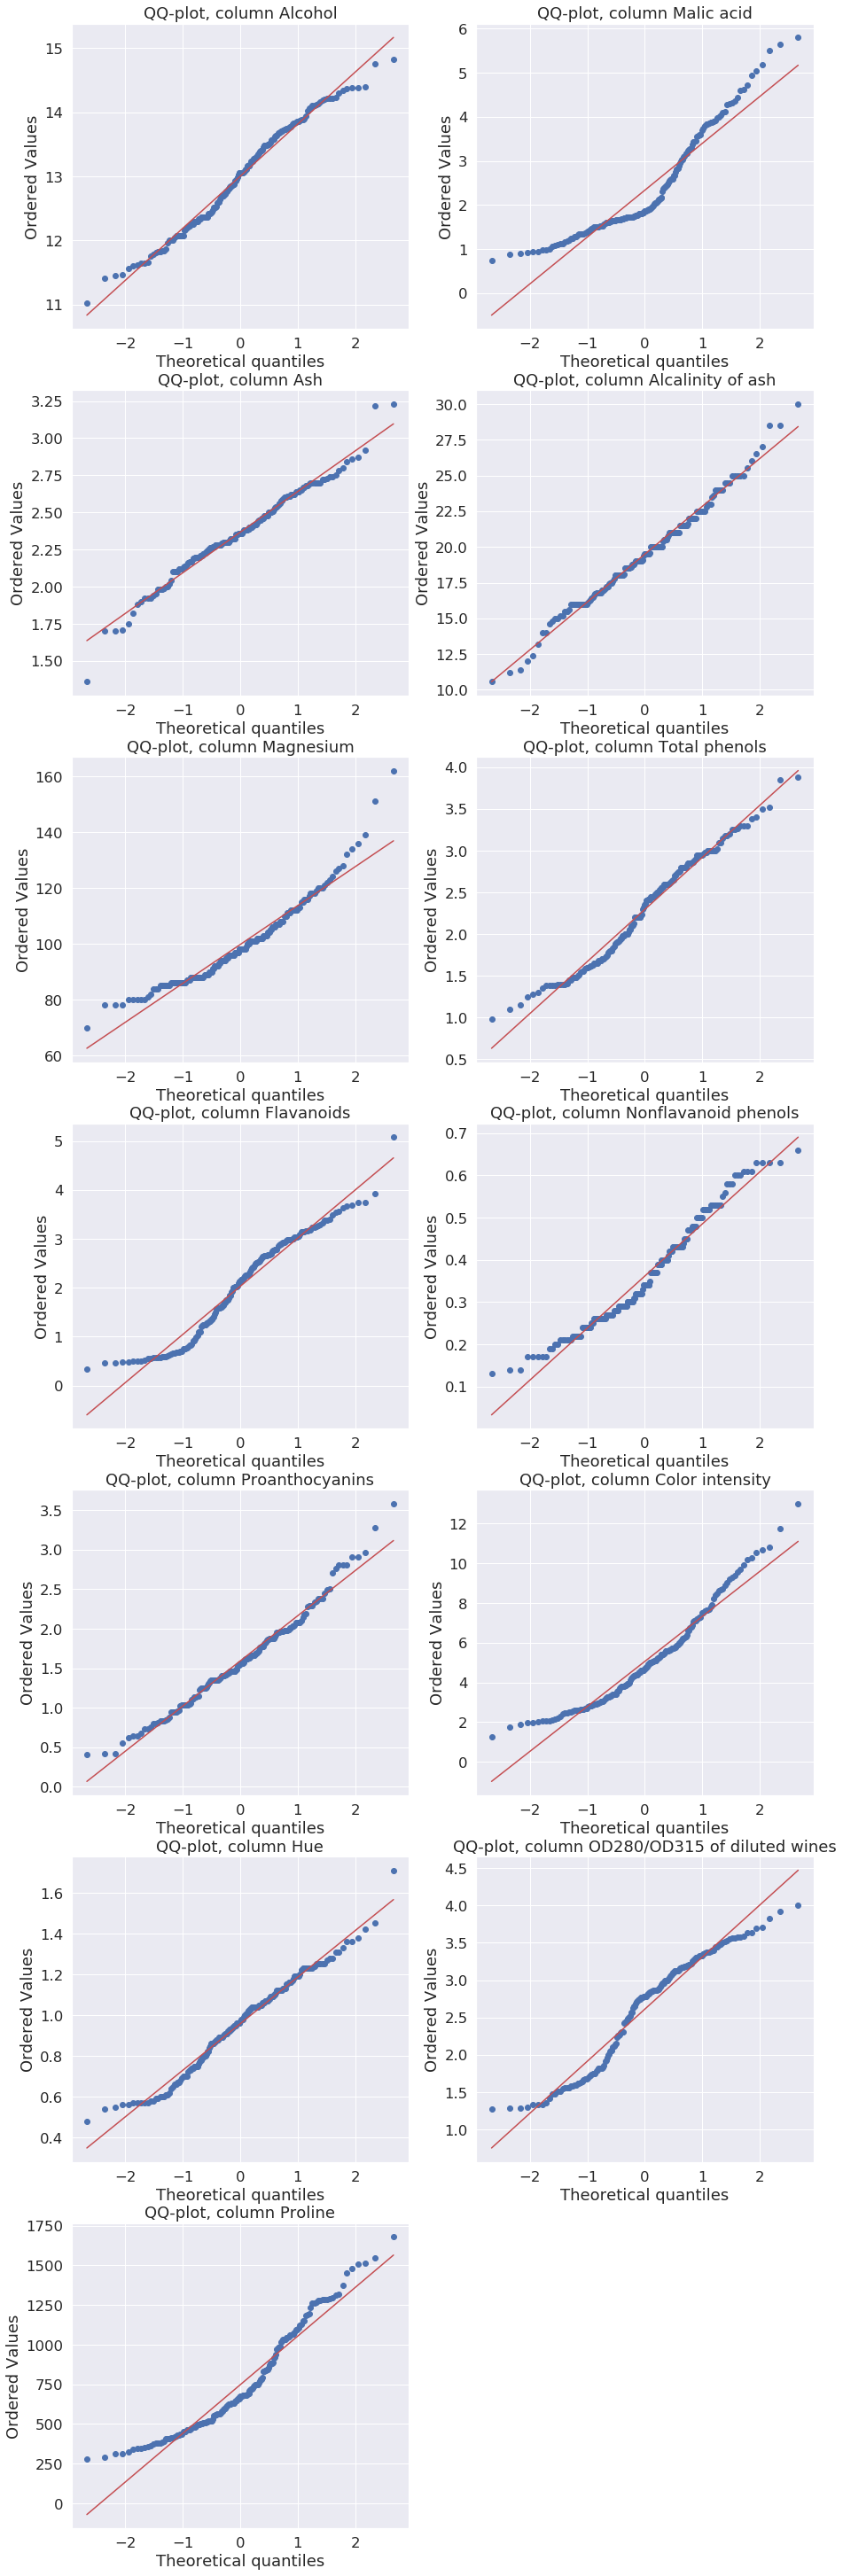

In [180]:
cols_cnt = len(wine_data.columns)
fig, axes = plt.subplots(int(np.ceil(cols_cnt / 2)), 2,
                         figsize=(15, 8 * cols_cnt / 2),
                        )

for i, col_name in enumerate(wine_data.columns):
    sample = wine_data[col_name]
    sps.probplot(sample, plot=axes[i // 2, i % 2])
    axes[i // 2, i % 2].set_title('QQ-plot, column ' + col_name)
fig.delaxes(axes[cols_cnt // 2, 1])

Для каких признаков можно говорить об их нормальности и почему?

**Ответ:** тут нет строгих формальных критериев, смотрим на отклонения от прямой и решаем, противоречит ли нормальности или нет. Лично я буду отклонять, если  есть сильные отклонения от прямой, в том числе и не хвостах. На мой взгляд, о нормальности следующих признаков можно говорить: *Alcohol, Ash, Alcalinity of ash, Total phenols, Proanthocyanins, Hue*.

Проверьте нормальность каждого признака статистическими критериями. Прежде чем выполнить следующую часть задачи, ответьте на вопросы. Помочь в этом может теоретическое домашнее задание 10.

Для каждого признака используйте несколько критериев проверки нормальности. Какие критерии вы будете использовать?

**Ответ:** Критерий Лиллиефорса, критерий Жарка-Бэра и критерий Шапиро-Уилка.

Результаты критериев нужно обработать с помощью *одной* процедуры множественной проверки гипотез для всех признаков и всех критериев сразу. Почему так нужно делать?

**Ответ:** так как мы хотим сразу каждый из признаков проверить на нормальность, у нас будет несколько гипотез и критериев для этих гипотез. Зачем нужно МПГ в таком случае? Чтобы контролировать FWER, потому что без МПГ ошибка первого рода может быть больше $\alpha$.

Какой метод для контроля FWER стоит применить и почему?

**Ответ:** так как мы контролируем FWER и нет какой-либо информации о зависимостях в данных, то стоит применить метод Холма, так как в таких условиях он неулучшаем.

Как понять из результата процедуры множественной проверки гипотез, нормальность каких признаков следует отклонить?

**Ответ:** метод Холла вернёт скорректированные значения p-value, которые и надо будет сравнить с $\alpha$ (я буду полагать $\alpha = 0.05$). Если $\widetilde{p}_j \le \alpha$, то отвергаем.

Если нормальность не отклоняется, что можно сказать про выборку? Ответ находится в презентации с лекции.

**Ответ:** согласуется??????TODO

Реализуйте данную схему. Предварительно соберите p-value всех критериев в таблицу. 

Функция `multipletests` принимает только одномерные массивы, поэтому для полученной `numpy`-таблицы нужно воспользоваться методом `ravel`. Результаты соберите обратно в таблицу с помощью метода `reshape`, которому необходимо передать размерности таблицы. Для наглядности сделайте таблицу с помощью `pandas.DataFrame`. В качестве названий строк используйте названия признаков, а названий столбцов — используемые критерии. В таблице должны присутстововать как значения p-value, так и результат проверки (`True` в случае отвержения).

In [224]:
from statsmodels.stats.diagnostic import lilliefors

# Посчитаем p-value для каждого критерия
cols_cnt = len(wine_data.columns)
criteria_cnt = 3
cr = lambda x: lilliefors(x, pvalmethod='approx')
criteria = np.array([cr, sps.jarque_bera, sps.shapiro])
p_vals = np.empty(shape=(criteria_cnt, cols_cnt))

# Специально расположим критерии по строкам, потому что если сделать как в
# условии, таблица получится вытянутой вниз и неудобной
for i, col_name in enumerate(wine_data.columns):
    sample = wine_data[col_name]
    for j, criterion in enumerate(criteria):
        p_vals[j, i] = criterion(sample)[1]

In [225]:
# Применим МПГ
alpha = 0.05
reject, pvals_corrected = multipletests(p_vals.ravel(), alpha,
                                        method='holm')[:2]
rejected = pd.DataFrame(reject.reshape(criteria_cnt, cols_cnt))
corr_pvals = pd.DataFrame(pvals_corrected.reshape(criteria_cnt, cols_cnt))

# Переименуем колонки
new_index = {i:name for i, name in enumerate(
    ['Lilliefors', 'Jarque-Bera', 'Shapiro-Wilk']
)}
new_col_names = {i:name for i, name in enumerate(wine_data.columns)}

pd.set_option("display.precision", 3)
corr_pvals.rename(index=new_index, columns=new_col_names)

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
Lilliefors,0.485,6.068e-16,0.933,0.550,3.228e-02,0.324,6.612e-02,1.608e-04,0.933,2.791e-02,0.550,9.914e-05,4.220e-06
Jarque-Bera,0.550,4.016e-06,0.153,0.933,2.616e-13,0.550,5.273e-01,1.821e-01,0.149,3.058e-04,0.933,6.612e-02,3.484e-03
Shapiro-Wilk,0.281,1.090e-08,0.464,0.933,2.094e-05,0.088,4.533e-04,2.744e-03,0.231,2.953e-05,0.261,7.180e-05,5.920e-06


In [226]:
rejected.rename(index=new_index, columns=new_col_names)

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
Lilliefors,False,True,False,False,True,False,False,True,False,True,False,True,True
Jarque-Bera,False,True,False,False,True,False,False,False,False,True,False,False,True
Shapiro-Wilk,False,True,False,False,True,False,True,True,False,True,False,True,True


Для каких признаков нормальность не отвергается?

**Ответ:** будем отвергать нормальность, если хотя бы один из критериев её отверг в МПГ, поэтому имеем: *Alcohol, Ash, Alcalinity of ash, Total phenols, Proanthocyanins, Hue*.

**Вывод:** я никак не корректировал свои ответы для QQ-plot, после получения результатов МПГ. Как мы видим, выбранные колонки один-в-один совпадают с результатами МПГ, так что QQ-plot вполне хороший метод для быстрой проверки на нормальность.

## Линейная регрессия
__________________
### Задача 4.

По шаблону напишите класс, реализующий линейную регрессию. Интерфейс этого класса в некоторой степени соответствует классу <a href="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression">`LinearRegression`</a> из библиотеки `sklearn`.

In [34]:
class LinearRegression:
    """
    Класс, реализующий линейную регрессию c помощью МНК.
    """
    
    def __init__(self, alpha=0.05):
        """       
        Параметр alpha --- уровень значимости критерия,
        (1-alpha) --- уровень доверия дов. интервала
        """
        self.alpha = alpha
        
    def fit(self, X, Y):
        """
        Функция обучения модели. 
        
        Предполагается модель Y = X * theta + epsilon. 
        где X --- регрессор (матрица размера n x d), 
        Y --- отклик (матрица размера n x 1),
        epsilon имеет нормальное распределение 
        с параметрами (0, sigma^2 * I_n).
        """
        
        self.n, self.d = X.shape
        
        inv_XX = np.linalg.inv(X.T @ X)
        self.inv_XX = inv_XX
        
        self.theta = inv_XX @ X.T @ Y # оценка на \theta
        self.sigma_sq = np.linalg.norm(Y - X @ self.theta)**2\
        / (self.n - self.d) # несмещённая оценка \sigma^2
        
        inv_XX_diag = np.diag(inv_XX)
        self.t = sps.t(df=self.n - self.d).ppf(1 - self.alpha / 2)
        # Доверительные интервалы для коэффициентов
        self.conf_int = np.vstack((
            self.theta - self.sigma_sq**0.5 * self.t * inv_XX_diag**0.5,
            self.theta + self.sigma_sq**0.5 * self.t * inv_XX_diag**0.5
        ))
        
        # статистики критериев о незначимости коэффициентов
        self.t_stats = self.theta / (self.sigma_sq * inv_XX_diag)**0.5

        # Так как критерий двухсторонний, нужно с двух сторон брать вер-ть
        # для p-value критериев о незначимости коэффициентов,
        # но в силу симметрии можно просто умножить на 2
        self.pvalue = 2 * sps.t(df=self.n - self.d).sf(np.abs(self.t_stats))
        
        return self
    
    def summary(self):
        """
        Печатает таблицу с информацией для каждого коэффициента,
        в которой указана его оценка, границы дов. интервала,
        статистика критерия и значение p-value
        """
        
        print(f'Линейная регрессия на {self.d} признаках и {self.n} объектах')
        print(f'Sigma: {self.sigma_sq:.6f}')
        
        # Далее напечатайте таблицу, 
        # в которой для каждого коэффициента (по строкам)
        # будут следующие столбцы:
        # оценка, границы дов. интервала (два столбца), 
        # статистика критерия, p-value
        print(pd.DataFrame(
            np.vstack((self.theta, self.conf_int[0, :], self.conf_int[1, :],
                       self.t_stats, self.pvalue
                      )).T,
            columns=['Оценка', 'Левая граница',
                     'Правая граница', 'Стат-ка критерия', 'p-value'
                  ]
        ))
        
    def predict(self, X, type_interval=None):
        """
        Возвращает предсказание отклика на новых объектах X 
        и опционально доверительный/предсказательный интервал.
        
        X --- матрица объектов размера n x d
        type_interval --- тип дов. интервала. 
        Для этого параметра возможны три варианта:
                        * None - возвратить только предсказание, 
                          размер return-a: n;
                        * 'confidence' - возвратить предсказание и 
                          доверительный интервал для среднего отклика, 
                          размер return-a: n x 3;
                        * 'prediction' - возвратить предсказание и 
                          предсказательный интервал для новых объектов, 
                          размер return-a: n x 3.
                        
        """
        
        y_pred = X @ self.theta
        
        if type_interval == None:
            return y_pred
        elif type_interval == 'confidence':
            sigma_corrected = (
                self.sigma_sq * np.diag(X @ self.inv_XX @ X.T)
            )**0.5
            return np.vstack((y_pred, y_pred - sigma_corrected * self.t, 
                              y_pred + sigma_corrected * self.t
                             )).T
        elif type_interval == 'prediction':
            sigma_corrected = (
                self.sigma_sq * np.diag(
                    X @ self.inv_XX @ X.T + np.eye(len(X))
                )
            )**0.5
            return np.vstack((y_pred, y_pred - sigma_corrected * self.t, 
                              y_pred + sigma_corrected * self.t
                             )).T
        else:
            assert True, f'Неизвестный тип интервала {type_interval}'

Загрузите данные о потреблении мороженного в зависимости от температуры воздуха и цены (файл `ice_cream.txt`).
Примените реализованный выше класс линейной регрессии к этим данным предполагая, что модель имеет вид $ic = \theta_1 + \theta_2\ t$, где $t$ — температура воздуха (столбец `temp`), $ic$ — постребление мороженного в литрах на человека (столбец `IC`).
Значения температуры предварительно переведите из Фаренгейта в Цельсий. Преобразование температуры по шкале Фаренгейта в температуру по шкале Цельсия: $t_C = \frac{(t_F - 32)}{1,8}$ 

К обученной модели примените фунцию `summary` и постройте график регрессии, то есть график прямой $ic = \widehat{\theta}_1 + \widehat{\theta}_2\ t$, где $\widehat{\theta}_1, \widehat{\theta}_2$ — МНК-оценки коэффициентов.
На график нанесите точки выборки. Постройте также доверительный интервал для среднего отклика и предсказательный интервал. В чем их различие? Проанализируйте результаты.

In [22]:
from pathlib import Path
path = Path.cwd()
path = path.joinpath('../../data/raw/MatStat5Sem')

ice_cream_data = pd.read_csv(path.joinpath('ice_cream.txt'), sep='\t')
ice_cream_data['temp'] = (ice_cream_data['temp'] - 32) / 1.8
ice_cream_data.head()

,date,IC,price,income,temp,Lag-temp,Year
0,1,0.386,0.270,78,5.000000,56,0
1,2,0.374,0.282,79,13.333333,63,0
2,3,0.393,0.277,81,17.222222,68,0
3,4,0.425,0.280,80,20.000000,69,0
4,5,0.406,0.272,76,20.555556,65,0


In [23]:
sample_size = len(ice_cream_data)
X = np.vstack((np.ones(sample_size), ice_cream_data['temp'])).T
Y = ice_cream_data['IC']

alpha = 0.05
regressor = LinearRegression(alpha)
regressor.fit(X, Y)

regressor.summary()

Линейная регрессия на 2 признаках и 30 объектах
Sigma: 0.001786
     Оценка  Левая граница  Правая граница  Стат-ка критерия       p-value
0  0.306298       0.283276        0.329319         27.253231  1.060446e-21
1  0.005593       0.003831        0.007355          6.502305  4.789215e-07


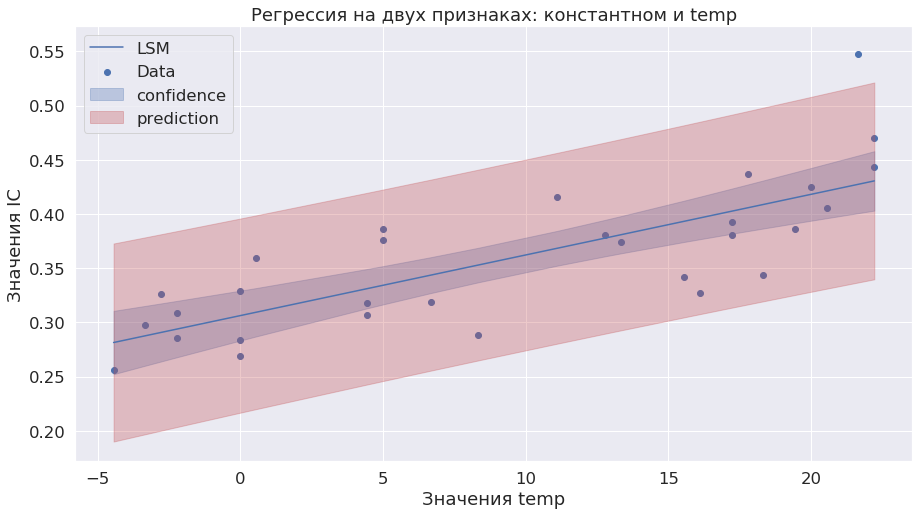

In [25]:
sns.set(style='darkgrid', font_scale=1.5)
plt.figure(figsize=(15, 8))

# Рисуем исходные данные и МНК оценку
plt.scatter(ice_cream_data['temp'], Y, c='b', marker='o', label='Data')
t = [ice_cream_data['temp'].min(), ice_cream_data['temp'].max()]
X_t = np.vstack((np.ones(2), t)).T
plt.plot(t, regressor.predict(X_t), label='LSM')

# Рисуем интервалы
ice_sorted = ice_cream_data.sort_values('temp')
X = np.vstack((np.ones(sample_size), ice_sorted['temp'])).T
pred_ans = regressor.predict(X, type_interval='confidence')
confidence = pred_ans[:,[1, 2]]
pred_ans = regressor.predict(X, type_interval='prediction')
prediction = pred_ans[:, [1, 2]]
plt.fill_between(ice_sorted['temp'], confidence[:, 0], confidence[:, 1],
                 alpha=0.3, label='confidence', color='b')
plt.fill_between(ice_sorted['temp'], prediction[:, 0], prediction[:, 1],
                 alpha=0.3, label='prediction', color='r')

plt.legend()
plt.title('Регрессия на двух признаках: константном и temp')
plt.xlabel('Значения temp')
plt.ylabel('Значения IC');

**Ответ.** Отличие в том, что в предсказательном интервале учтён вклад случайного шума в данных, а в среднем отклике этого вклада нет (в нашей модели мат. ож. шума равен 0). Действительно, почти все исходные данные попали в 0.95-предсказательный интервал.

Теперь учтите влияние года (столбец `Year`) для двух случаев:
* модель $ic = \theta_1 + \theta_2\ t + \theta_3 y_1 + \theta_4 y_2$, где $y_1 = I\{1\ год\}, y_2 = I\{2\ год\}$. Поясните, почему нельзя рассмативать одну переменную $y$ — номер года.
* для каждого года рассматривается своя линейная зависимость $ic = \theta_1 + \theta_2\ t$.

В каждом случае нарисуйте графики. Отличаются ли полученные результаты? Почему? От чего это зависит? Как зависит потребление мороженного от года? 

In [32]:
# Обучим для всех лет сразу
mask1 = np.zeros(len(ice_cream_data))
mask1[ice_cream_data['Year'] == 1] = 1.0
mask2 = np.zeros(len(ice_cream_data))
mask2[ice_cream_data['Year'] == 2] = 1.0
X = np.vstack((np.ones(sample_size), ice_cream_data['temp'], mask1, mask2)).T
ultimate_regressor = LinearRegression(alpha)
ultimate_regressor.fit(X, Y);

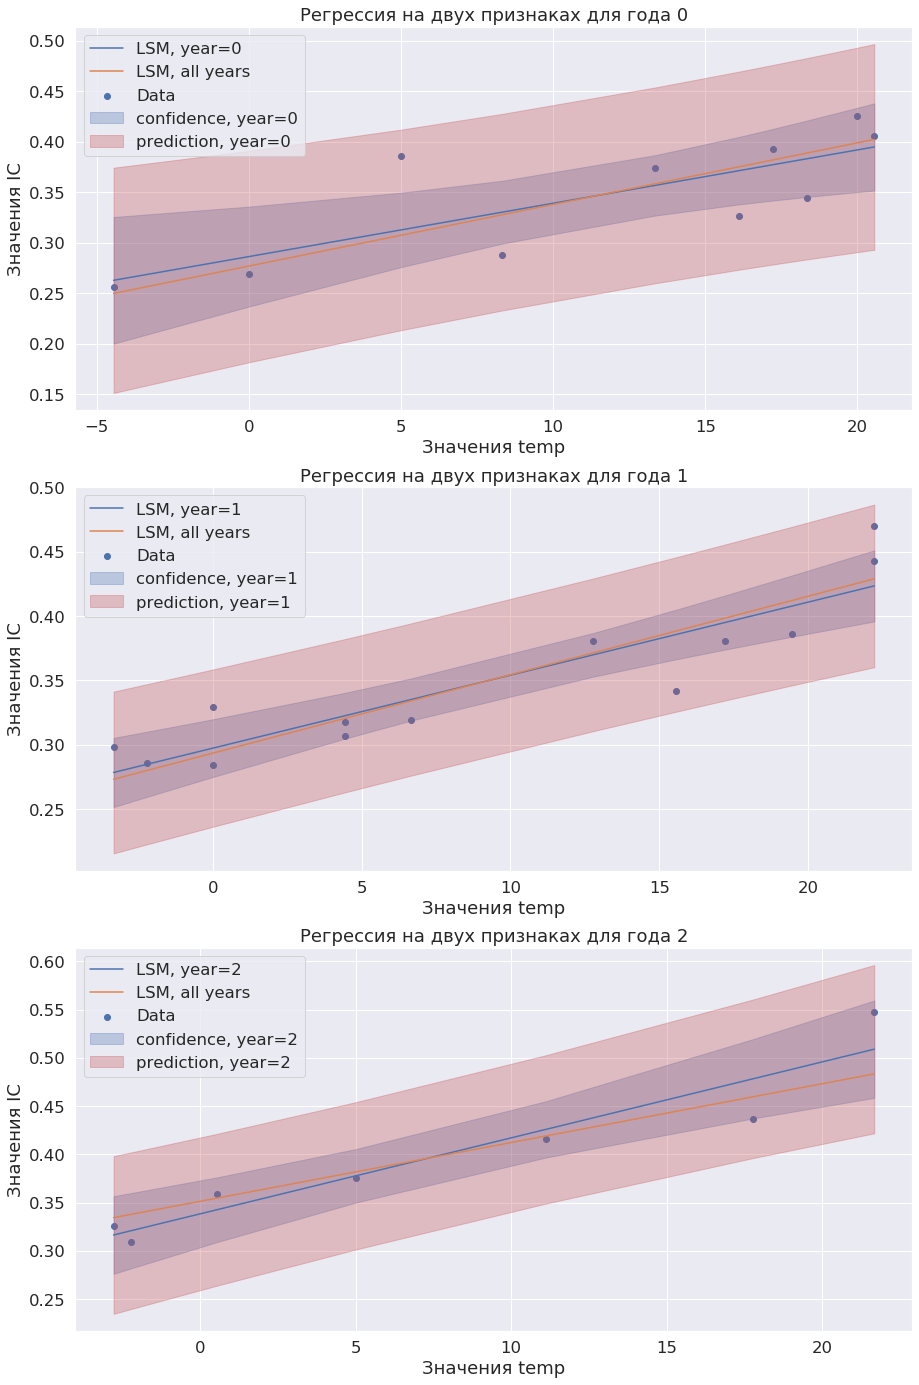

In [37]:
# Теперь для каждого года в отдельности обучаем модель
# и рисуем графики
plt.figure(figsize=(15, 12 * ice_cream_data['Year'].max()))

for year in range(ice_cream_data['Year'].max() + 1):
    cur_year_ice = ice_cream_data[ice_cream_data['Year'] == year]
    X = np.vstack((np.ones(len(cur_year_ice)), cur_year_ice['temp'])).T
    Y = cur_year_ice['IC']
    regressor.fit(X, Y)
    
    # Отрисовка МНК и данных
    ax = plt.subplot(3, 1, year + 1)
    ax.scatter(cur_year_ice['temp'], Y, c='b', marker='o', label='Data')
    t = [cur_year_ice['temp'].min(), cur_year_ice['temp'].max()]
    X_t = np.vstack((np.ones(2), t)).T
    ax.plot(t, regressor.predict(X_t), label='LSM, year={0}'.format(year))
    year_1 = np.array([year == 1] * 2)
    year_2 = np.array([year == 2] * 2)
    X_t = np.vstack((np.ones(2), t, year_1, year_2)).T
    ax.plot(t, ultimate_regressor.predict(X_t), label='LSM, all years')
    

    # Рисуем интервалы
    ice_sorted = cur_year_ice.sort_values('temp')
    X = np.vstack((np.ones(len(ice_sorted)), ice_sorted['temp'])).T
    pred_ans = regressor.predict(X, type_interval='confidence')
    confidence = pred_ans[:, [1, 2]]
    pred_ans = regressor.predict(X, type_interval='prediction')
    prediction = pred_ans[:, [1, 2]]
    ax.fill_between(ice_sorted['temp'], confidence[:, 0], confidence[:, 1],
                    alpha=0.3, label='confidence, year={0}'.format(year),
                    color='b')
    ax.fill_between(ice_sorted['temp'], prediction[:, 0], prediction[:, 1],
                    alpha=0.3, label='prediction, year={0}'.format(year),
                    color='r')

    plt.legend()
    plt.title('Регрессия на двух признаках для года {0}'.format(year))
    plt.xlabel('Значения temp')
    plt.ylabel('Значения IC')

**Ответ.** 1) Для категориальной переменной нельзя рассматривать её значения в качестве признаков, иначе линейная регрессия будет эти значения учитывать, а именно, например, в данном случае $\theta_4$ всегда была бы с коэффициентом $2$, а $\theta_3$ --- с $1$ в свои года. Тогда это могло бы создать некоторый "перевес" в сторону большего учёта значений второго года моделью.

2) Видим, что результаты отличаются слабо: немного разные наклоны у прямых. Также можно заметить, что потребление мороженого во второй год было больше, чем в первый и нулевой. Как раз поэтому угол наклона у линии регрессии по всем годам чуть больше, чем у линий первого и нулевого годов, и поменьше, чем у линии второго года. 

Наконец, обучите модель на предсказание потребления мороженного в зависимости от всех признаков, кроме `Lag-Temp`.
Не забудьте, что для года нужно ввести две переменных.
Для полученной модели выведите `summary`.

In [38]:
# Обучим на всех признаках, кроме Lag-Temp
mask1 = np.zeros(len(ice_cream_data))
mask1[ice_cream_data['Year'] == 1] = 1.0
mask2 = np.zeros(len(ice_cream_data))
mask2[ice_cream_data['Year'] == 2] = 1.0
X = np.vstack((np.ones(sample_size), ice_cream_data['temp'], mask1, mask2,
               ice_cream_data['date'], ice_cream_data['price'],
               ice_cream_data['income']
              )).T
Y = ice_cream_data['IC']
regressor.fit(X, Y)

regressor.summary()

Линейная регрессия на 7 признаках и 30 объектах
Sigma: 0.000887
     Оценка  Левая граница  Правая граница  Стат-ка критерия       p-value
0  0.672908       0.109237        1.236578          2.469555  2.137947e-02
1  0.005974       0.004535        0.007414          8.583939  1.254192e-08
2  0.073464       0.020505        0.126424          2.869580  8.661930e-03
3  0.175541       0.083011        0.268070          3.924530  6.783852e-04
4 -0.003525      -0.007400        0.000350         -1.881874  7.256823e-02
5 -0.819279      -2.461801        0.823243         -1.031833  3.128793e-01
6 -0.001925      -0.006391        0.002541         -0.891552  3.818656e-01


Но это еще не все.
Постройте теперь линейную регрессию для модели $ic = \theta_1 + \theta_2\ t + \theta_3\ t^2 + \theta_4\ t^3$.
Выведите для нее summary и постройте график предсказания, то есть график кривой $ic = \widehat{\theta}_1 + \widehat{\theta}_2\ t + \widehat{\theta}_3\ t^2 + \widehat{\theta}_4\ t^3$. Хорошие ли получаются результаты?

In [39]:
X = np.vstack((np.ones(sample_size), ice_cream_data['temp'], 
               ice_cream_data['temp']**2, ice_cream_data['temp']**3
              )).T
Y = ice_cream_data['IC']
regressor.fit(X, Y)

regressor.summary()

Линейная регрессия на 4 признаках и 30 объектах
Sigma: 0.001529
     Оценка  Левая граница  Правая граница  Стат-ка критерия       p-value
0  0.319902       0.295294        0.344510         26.721959  1.957227e-20
1  0.007200       0.000388        0.014013          2.172538  3.911764e-02
2 -0.000855      -0.001861        0.000152         -1.745679  9.267541e-02
3  0.000038       0.000002        0.000073          2.180118  3.849208e-02


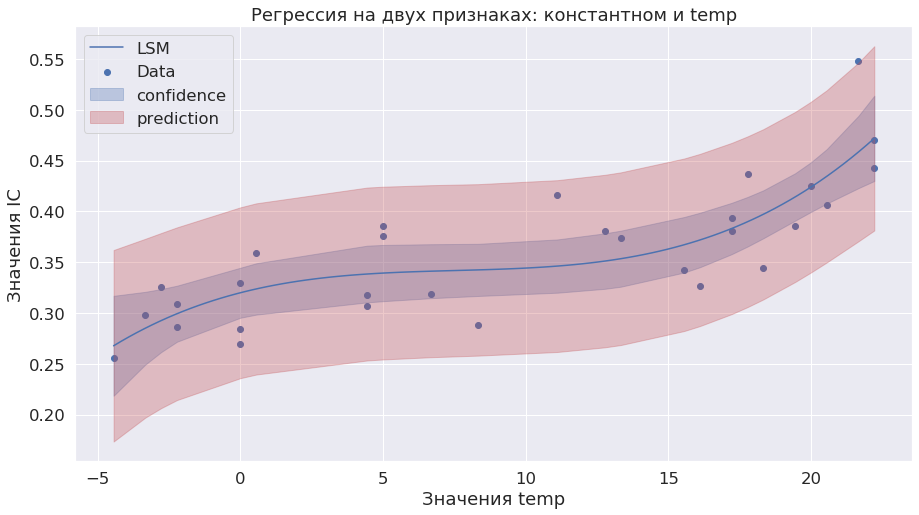

In [40]:
plt.figure(figsize=(15, 8))

# Рисуем исходные данные и МНК оценку
plt.scatter(ice_cream_data['temp'], Y, c='b', marker='o', label='Data')
t = np.linspace(ice_cream_data['temp'].min(), ice_cream_data['temp'].max(),
               100)
X_t = np.vstack((np.ones(100), t, t**2, t**3)).T
plt.plot(t, regressor.predict(X_t), label='LSM')

# Рисуем интервалы
ice_sorted = ice_cream_data.sort_values('temp')
X = np.vstack((np.ones(sample_size), ice_sorted['temp'], 
               ice_sorted['temp']**2, ice_sorted['temp']**3
              )).T
pred_ans = regressor.predict(X, type_interval='confidence')
confidence = pred_ans[:, [1, 2]]
pred_ans = regressor.predict(X, type_interval='prediction')
prediction = pred_ans[:, [1, 2]]
plt.fill_between(ice_sorted['temp'], confidence[:, 0], confidence[:, 1],
                 alpha=0.3, label='confidence', color='b')
plt.fill_between(ice_sorted['temp'], prediction[:, 0], prediction[:, 1],
                 alpha=0.3, label='prediction', color='r')

plt.legend()
plt.title('Регрессия на двух признаках: константном и temp')
plt.xlabel('Значения temp')
plt.ylabel('Значения IC');

**Ответ:** я бы не сказал, что получаются плохие результаты =))))).

Чтобы понять, почему так происходит, выведите значения матрицы $(X^T X)^{-1}$ для данной матрицы и посчитайте для нее индекс обусловленности $\sqrt{\left.\lambda_{max}\right/\lambda_{min}}$, где $\lambda_{max}, \lambda_{min}$ — максимальный и минимальный собственные значения матрицы $X^T X$. Собственные значения можно посчитать функцией <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.eigvals.html">`scipy.linalg.eigvals`</a>.

Прокомментируйте полученные результаты. Помочь в этом может следующая <a href="https://ru.wikipedia.org/wiki/%D0%A7%D0%B8%D1%81%D0%BB%D0%BE_%D0%BE%D0%B1%D1%83%D1%81%D0%BB%D0%BE%D0%B2%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D1%81%D1%82%D0%B8">статья</a>.

In [41]:
from scipy.linalg import eigvals

X = np.vstack((np.ones(sample_size), ice_cream_data['temp'], 
               ice_cream_data['temp']**2, ice_cream_data['temp']**3
              )).T
inv_XX = np.linalg.inv(X.T @ X)
print('Сама матрица:\n', inv_XX)

eig_values = np.abs(eigvals(X.T @ X))
print('Её число обусловленности: {0:.3f}'.format(
    (eig_values.max() / eig_values.min())**0.5
))

Сама матрица:
 [[ 9.37480084e-02  3.89861423e-03 -1.78656900e-03  6.69029822e-05]
 [ 3.89861423e-03  7.18536599e-03 -8.80905447e-04  2.52158328e-05]
 [-1.78656900e-03 -8.80905447e-04  1.56779604e-04 -5.35416603e-06]
 [ 6.69029822e-05  2.52158328e-05 -5.35416603e-06  1.95858936e-07]]
Её число обусловленности: 8140.395


**Вывод.** 1) Чем больше число обусловленности, тем больше дисперсия у оценок. В данном случае на графике это не сильно заметно, но если немного увеличить пределы по $t$, то на краях будет быстрый рост размеров интервала (в принципе, на краях это заметно и на обычном графике).

2) Интересно отметить, что при построении по 7-ми признакам, для `price` и `income` гипотеза о незначимости не отвергается, хотя казалось бы, что цена напрямую влияет на количество съеденного мороженого.

__________________
### Задача 5.

В данной задаче нужно реализовать функцию отбора признаков для линейной регрессии. Более подробно, пусть у объектов есть признаки $x_1, ... , x_k$. Нужно определить, какое подмножество признаков $x_{j_1}, ... , x_{j_s}$ нужно использовать, чтобы качество полученной модели $y = \theta_0 + \theta_{j_1} x_{j_1} + ... + \theta_{j_s} x_{j_s}$ было максимальным.

Один из методов, решающих эту задачу описан далее.

Сначала имеющаяся выборка случайно разделяется на обучающую выборку и тестовую (train и test). Для некоторого подмножества признаков на обучающей выборке обучается модель, после чего вычисляется её качество на тестовой выборке. Операция повторяется для всех подмножеств признаков. Лучшей считается модель с наилучшим качеством на тестовой выборке.

Иначе говоря, сначала выборка $X$ разделяется по объектам на $X_{train} \sqcup X_{test} = X$ . Далее, в цикле по всем подмножествам индексов признаков $(j_1, \dots, j_s)$ на обучающей выборке $X_{train}$ обучается модель $y = \theta_{j_1} x_{j_1} + ... + \theta_{j_s} x_{j_s}$, после чего считается её качество на $X_{test}$.

В данной задаче под метрикой качества понимается средний квадрат ошибки (mean squared error)

$$MSE = \frac{1}{n} \sum\limits_{x \in X_{test}} \left(\widehat{y}(x) - Y(x)\right)^2,$$
где $x$ — объект, $Y(x)$ — значение целевой переменной (отклика) на объекте $x$, а $\widehat{y}(x)$ — оценка отклика на объекте $x$.

Заметим, что полный перебор подмножеств признаков требует большого времени. Проблема отбора признаков состоит в том, что могут быть два признака, добавление каждого из которых ухудшает (не улучшает) качество, но добавление двух признаков сразу увеличивает качество.

Для выполнения задания воспользуйтесь следующими функциями:
* <a href="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression">`sklearn.linear_model.LinearRegression`</a> — реализация линейной регрессии. В данной реализации свободный параметр $\theta_1$ по умолчанию автоматически включается в модель. Отключить это можно с помощью `fit_intercept=False`, но это не нужно. *В данной задаче требуется, чтобы вы воспользовались готовой реализацией линейной регрессии, а не своей. Ведь на практике важно уметь применять готовые реализации, а не писать их самостоятельно.*

* <a href="http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html">`sklearn.model_selection.train_test_split`</a> — функция разбиения данных на train и test. Установите параметр `test_size=0.3` и `random_state=17`.

* <a href="http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html">`sklearn.metrics.mean_squared_error`</a> — реализация MSE.

Для перебора реализуйте следующий класс. Данный класс частично реализует интерфейс, похожий на интерфейс <a href="http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html">`sklearn.model_selection.GridSearchCV`</a>

In [2]:
class BestFeaturesSelection:
    """
    Класс, реализующий отбор наилучших признаков.
    """
    
    def __init__(self, estimator, scoring, parameters=dict(), 
                 test_size=0.3, random_state=17, minimize=True):
        """
        estimator: конструктор класса, например, LinearRegression
        scoring: функция риска, например, mean_squared_error
        parameters: параметры, передаваемые конструктору estimator, 
                   например dict(fit_intercept=False)
        test_size: доля тестовой выборки
        random_state: random state
        minimize: минимизировать ли функционал качества, 
                  если True - минимизровать, иначе - максимизировать
        """
        
        self.estimator = estimator
        self.parameters = parameters
        self.scoring = scoring
        self.test_size = test_size
        self.random_state = random_state
        self.minimize = minimize
        
    def fit(self, X, y):
        """
        Подбор лучшего подмножества признаков и обучение модели на нём.
        
        X: регрессор (матрица размера n x d)
        y: отклик (матрица n x 1)
        
        Возвращает:
        best_estimator: объект класса self.estimator, обученный
                        на наилучшем подмножестве признаков по
                        функции риска self.scoring
        """
        
        # разделение выборки на test и train. Не перепутайте порядок!
        X_train, X_test, y_train, y_test =  train_test_split(
            X, y,
            test_size=self.test_size,
            random_state=self.random_state
        )
        # список пар (вектор использованных признаков, знач. функции потерь)
        self.results_ = []
        features_count = X.shape[1]
        # перебор по всем подмножествам признаков
        for bitmask in range(1, 2 ** features_count):
            # получим рассматриваемое подмножество признаков
            subset = [i == "1" for i in \
                      np.binary_repr(bitmask, width=features_count)]
            
            # вычисление качества модели
            trained_model = self.estimator(**self.parameters).fit(
                X_train.iloc[:, subset], y_train
            )
            score = self.scoring(y_test,
                                 trained_model.predict(X_test.iloc[:, subset])
                                )
            self.results_.append((subset, score))
        
        # сортируем по второму элементу в нужном порядке
        self.results_.sort(key=lambda pair: pair[1], 
                           reverse=not self.minimize)
        # сохраним лучшее подмножество признаков
        self._best_subset = self.results_[0][0]
        # создадим объект класса self.estimator 
        self._best_estimator = self.estimator(**self.parameters)
        # обучимся на лучшем подмножестве признаков
        self._best_estimator.fit(X_train.iloc[:, self._best_subset], 
                                 y_train)
        
        return self._best_estimator
        
    def predict(self, X):
        """
        Предсказание модели, обученной на наилучшем подмножестве признаков.
        
        X: объекты (матрица размера n x d)
        """
        return self._best_estimator.predict(X[:, self._best_subset])

Примените реализованный отбор признаков к датасетам
* <a href="http://archive.ics.uci.edu/ml/datasets/Yacht+Hydrodynamics">Yacht Hydrodynamics</a> — для парусных яхт нужно оценить остаточное сопротивление на единицу массы смещения (последний столбец) в зависимости от различных характеристик яхты.

* <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston">Boston Housing Prices</a> — цены на дома в Бостоне в зависимости от ряда особенностей.

Посмотрите на графики зависимости целевой переменной от каждого признака. Какие бы признаки вы стали использовать? Совпадает ли ваш выбор с результатом процедуры, описанного выше? 

In [3]:
from pathlib import Path
path = Path.cwd()
path = path.joinpath('../../data/raw/MatStat5Sem')

col_names = ['Longitudinal position', 'Prismatic coefficient',
             'Length-displacement ratio', 'Beam-draught ratio',
            'Length-beam ratio', 'Froude number', 'Residuary resistance']

yacht_data = pd.read_csv(path.joinpath('yacht_hydrodynamics.data'),
                         names = col_names, sep=' ')
yacht_data.head()

,Longitudinal position,Prismatic coefficient,Length-displacement ratio,Beam-draught ratio,Length-beam ratio,Froude number,Residuary resistance
0,-2.3,0.568,4.78,3.99,3.17,0.125,0.11
1,-2.3,0.568,4.78,3.99,3.17,0.150,0.27
2,-2.3,0.568,4.78,3.99,3.17,0.175,0.47
3,-2.3,0.568,4.78,3.99,3.17,0.200,0.78
4,-2.3,0.568,4.78,3.99,3.17,0.225,1.18


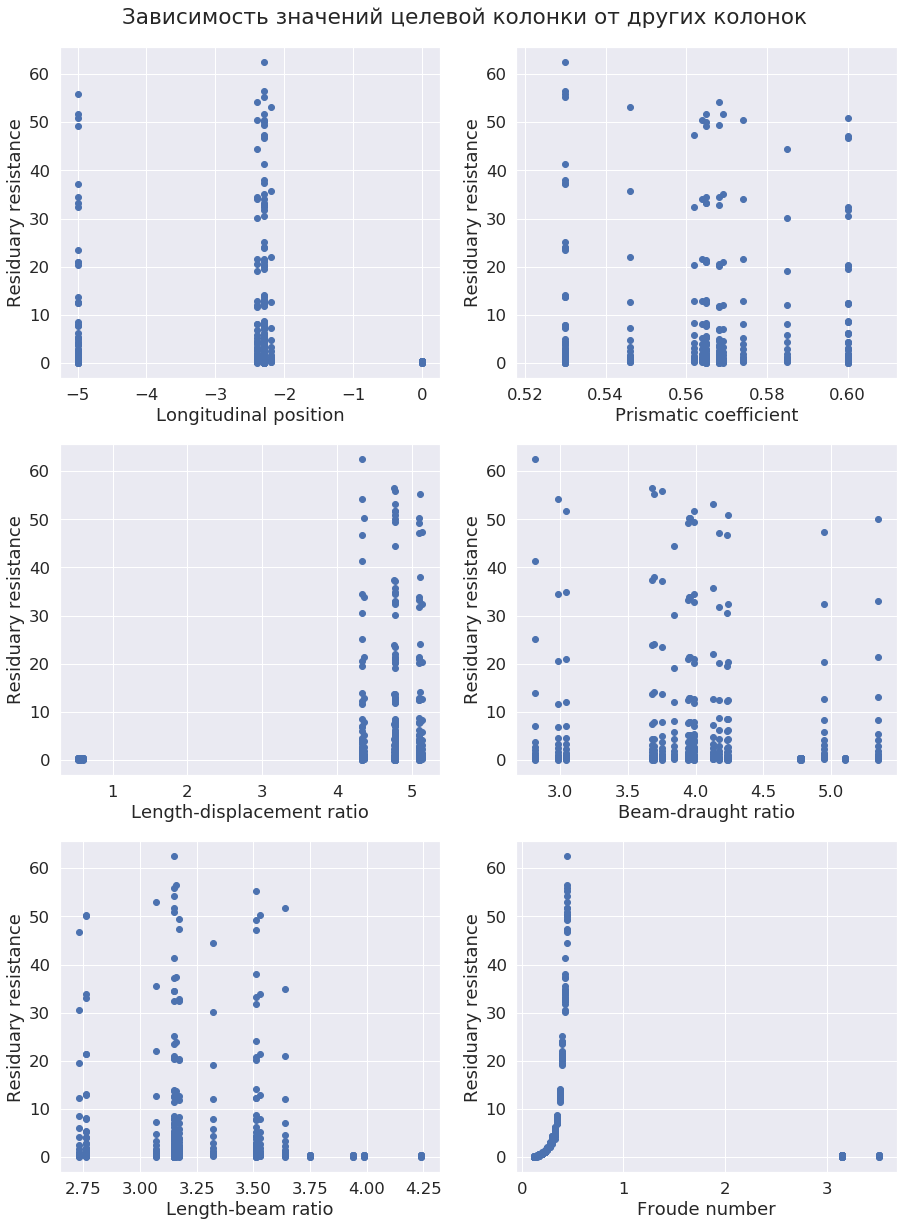

In [4]:
sns.set(style='darkgrid', font_scale=1.5)
cols_cnt = len(yacht_data.columns)
fig, axes = plt.subplots(int(np.ceil(cols_cnt / 2)), 2,
                         figsize=(15, 8 * cols_cnt / 2),
                        )
plt.suptitle('Зависимость значений целевой колонки от других колонок', y=0.9)

for i, col_name in enumerate(yacht_data.columns):
    if str(col_name) != 'Residuary resistance':
        sample = yacht_data[col_name]
        axes[i // 2, i % 2].scatter(sample,
                                    yacht_data['Residuary resistance'])
        axes[i // 2, i % 2].set_xlabel(col_name)
        axes[i // 2, i % 2].set_ylabel('Residuary resistance')
fig.delaxes(axes[cols_cnt // 2, 0])
fig.delaxes(axes[cols_cnt // 2, 1])

**Ответ.** Зависимость прослеживается от *Froude number*: на вид квадратичная функция. Значения в остальных же колонках расщеплены на группы, бОльшая часть которых имеет значения *Residuary resistance* во всём диапазоне, поэтому можно говорить об отсутствии зависимости.

Проверим теперь, что скажет `BestFeaturesSelection`.

In [6]:
best_feats = BestFeaturesSelection(LinearRegression, mean_squared_error)

yacht_data.dropna(inplace=True)
best_feats.fit(yacht_data[yacht_data.columns[:-1]],
               yacht_data[yacht_data.columns[-1]])
print('Признак(-и), при которых модель минимизирует MSE:')
answer = np.empty(shape=0, dtype=str)
for i in range(cols_cnt - 1):
    if best_feats._best_subset[i]:
        answer = np.append(answer, str(col_names[i]))
print(answer)

Признак(-и), при которых модель минимизирует MSE:
['Prismatic coefficient' 'Froude number']


**Вывод.** Таким образом, `BestFeaturesSelection` выбрал не только `Froude number`, но ещё и `Prismatic coefficient`. Оказывается, вместе они дают лучший результат.

Проделаем аналогичное исследование для *Boston Housing Prices*.

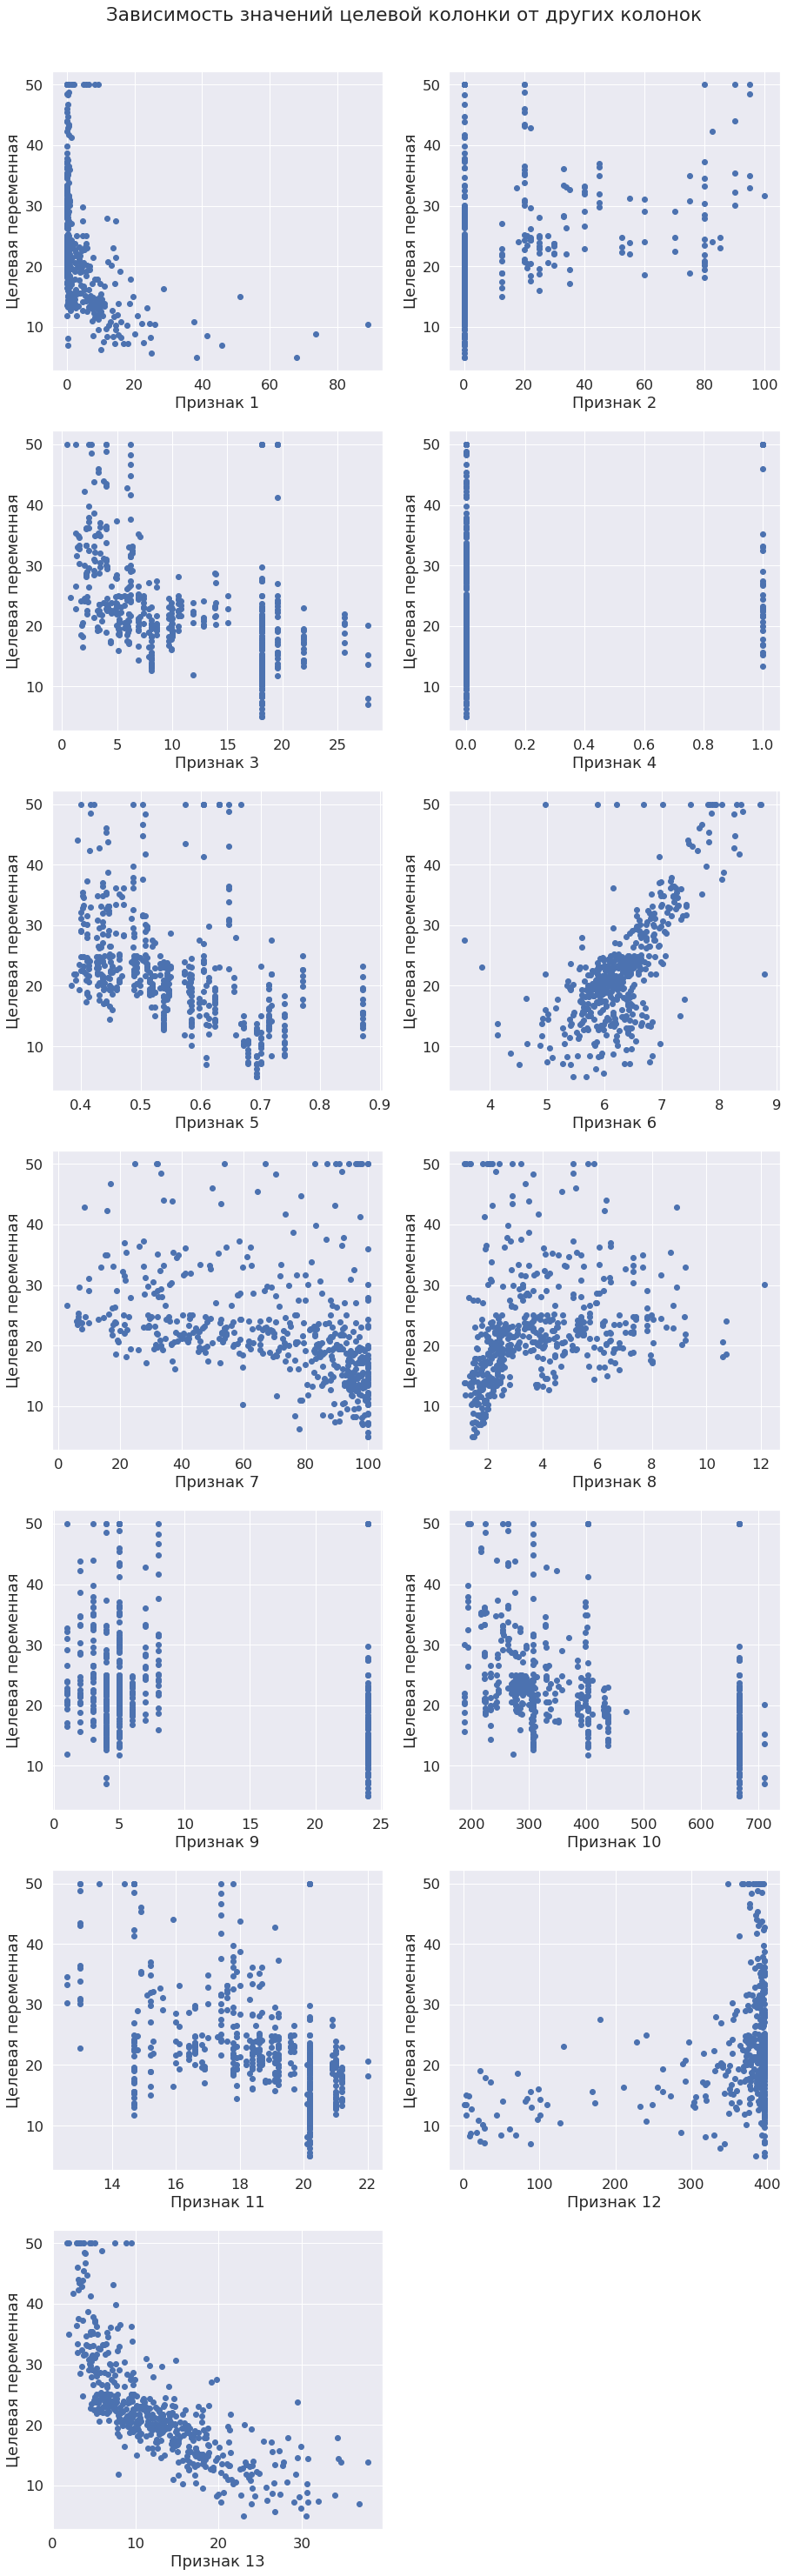

In [7]:
X, y = load_boston(return_X_y=True)

cols_cnt = X.shape[1]
fig, axes = plt.subplots(
    int(np.ceil(cols_cnt / 2)), 2, figsize=(15, 8 * cols_cnt / 2)
)
plt.suptitle('Зависимость значений целевой колонки от других колонок', y=0.9)

for j in range(X.shape[1]):
    sample = X[:, j]
    axes[j // 2, j % 2].scatter(sample, y)
    axes[j // 2, j % 2].set_xlabel('Признак ' + str(j + 1))
    axes[j // 2, j % 2].set_ylabel('Целевая переменная')
fig.delaxes(axes[cols_cnt // 2, 1])

**Ответ.** На мой взгляд зависимости есть от 6, 8, 13 признаков. Поясню: на 6-м графике хорошо прослеживается линейная зависимость; на 8-м графике левый нижний угол напоминает линейную зависимость, да и в целом данные, хоть и становятся сильно разбросанными, всё равно ложатся на линейность; на 13-м графике на лицо явная гипербола.

Посмотрим, что скажет `BestFeaturesSelection`.

In [9]:
best_feats = BestFeaturesSelection(LinearRegression, mean_squared_error)
best_feats.fit(pd.DataFrame(X), y)

print('Признак(-и), при которых модель минимизирует MSE:')
answer = np.empty(shape=0, dtype=str)
for i in range(cols_cnt):
    if best_feats._best_subset[i]:
        answer = np.append(answer, str(i + 1))
print(answer)

Признак(-и), при которых модель минимизирует MSE:
['1' '2' '5' '6' '8' '9' '10' '11' '12' '13']


**Вывод.** `BestFeaturesSelection` нашёл куда больше полезных зависимостей, ухууу! И всё же некоторые признаки были отброшены, потому что не улучшают качество модели.

**Общий вывод.** Во-первых, задача отлично демонстрирует, что далеко не все признаки нужны. Во-вторых, вопрос отбора нужных признаков остаётся открытым: если $d$ небольшое (порядка 10), причём $n$ тоже ($n^3\cdot 2^d\le 10^9$, так как обращение матрицы делается в общем случае за $n^3$), то можно смело запускать `BestFeaturesSelection` и отбирать наилучшие. А вот что делать, если d порядка 100 и больше, хороший вопрос...